<a href="https://colab.research.google.com/github/ritwikraha/GenerativeFill-with-Keras-and-Diffusers/blob/main/g-dino-sam-mask-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [1]:
!pip install -qq --upgrade keras-cv tensorflow
!pip install -qq --upgrade keras
!pip install -qq git+https://github.com/IDEA-Research/GroundingDINO.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
  Preparing metadata (setup.py) ... done


In [2]:
import os; os.environ["KERAS_BACKEND"]="tensorflow"

import numpy as np
from matplotlib import pyplot as plt

import keras
from keras import ops
import keras_cv

import torch

from groundingdino.util.inference import Model as GroundingDINO

## Load the image

In [3]:
!wget -q https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

In [44]:
def inference_resizing(image, pad=True):
    image = ops.cast(image, dtype="float32")
    image = ops.image.resize(
        ops.expand_dims(image, 0),
        (1024, 1024)
    )[0]
    return image

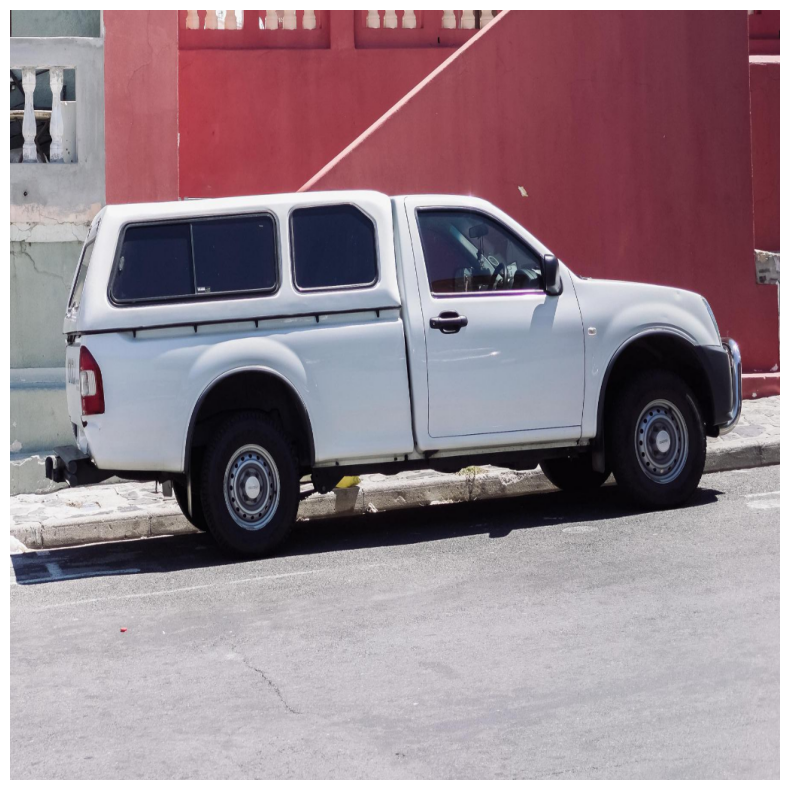

In [45]:
# Load our image
image = np.array(keras.utils.load_img("truck.jpg"))
image = ops.convert_to_numpy(
    inference_resizing(image, True)
)

plt.figure(figsize=(10, 10))
plt.imshow(image.astype(np.uint8))
plt.axis("off")
plt.show()

In [46]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

## Get the bounding boxes from text prompts

In [7]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

In [8]:
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [47]:
object_wanted = "wheel"
boxes = grounding_dino.predict_with_caption(
    image.astype(np.uint8),
    object_wanted,
)
boxes = np.array(boxes[0].xyxy)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


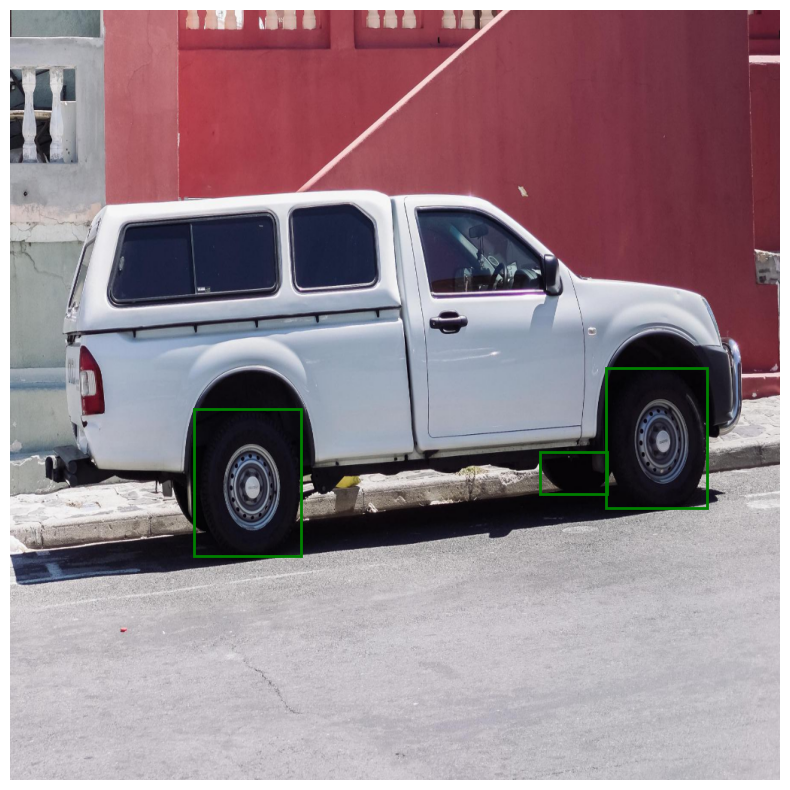

In [49]:
plt.figure(figsize=(10, 10))
plt.imshow(image.astype("uint8"))
for i in range(boxes.shape[0]):
    show_box(boxes[i], plt.gca())
plt.axis("off")
plt.show()

## Use the SAM model for segmentation mask

In [50]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_base_sa1b")
outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step


In [51]:
masks = outputs["masks"][:, 0:1, ...]
masks.shape

(3, 1, 256, 256)

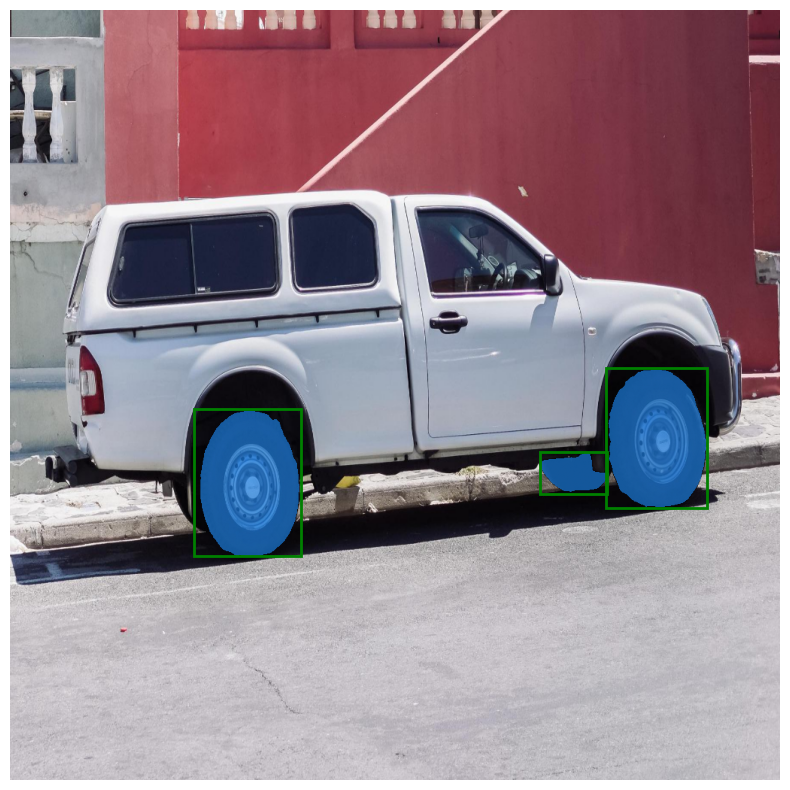

In [52]:
plt.figure(figsize=(10, 10))
plt.imshow(image.astype("uint8"))

# iterate on each box and mask
num_boxes = ops.shape(boxes)[0]
for i in range(num_boxes):
    box = boxes[i]
    mask = masks[i, 0]
    mask = ops.convert_to_numpy(
        inference_resizing(mask[..., None])[..., 0]
    ) > 0.0
    show_box(box, plt.gca())
    show_mask(mask, plt.gca())

plt.axis("off")
plt.show()